In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 15      
DATA_ROOT = r"D:\dataset_split"
LEARNING_RATE = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/train", transform = train_transform)
val_dataset   = datasets.ImageFolder(root = f"{DATA_ROOT}/val", transform = val_transform)

targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler = sampler)
val_loader   = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*56*56, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=15, bias=True)
  )
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss, running_correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = running_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



Epoch [1/15] Train Loss: 1.8784 | Train Acc: 0.3815 | Val Loss: 1.3182 | Val Acc: 0.5486
Epoch [2/15] Train Loss: 1.2317 | Train Acc: 0.5909 | Val Loss: 0.8279 | Val Acc: 0.7376
Epoch [3/15] Train Loss: 1.0325 | Train Acc: 0.6539 | Val Loss: 0.7651 | Val Acc: 0.7386
Epoch [4/15] Train Loss: 0.9396 | Train Acc: 0.6846 | Val Loss: 0.6361 | Val Acc: 0.7809
Epoch [5/15] Train Loss: 0.8692 | Train Acc: 0.7075 | Val Loss: 0.6052 | Val Acc: 0.7945
Epoch [6/15] Train Loss: 0.8158 | Train Acc: 0.7298 | Val Loss: 0.6005 | Val Acc: 0.7979
Epoch [7/15] Train Loss: 0.7527 | Train Acc: 0.7429 | Val Loss: 0.5522 | Val Acc: 0.8105
Epoch [8/15] Train Loss: 0.6951 | Train Acc: 0.7658 | Val Loss: 0.5162 | Val Acc: 0.8275
Epoch [9/15] Train Loss: 0.6572 | Train Acc: 0.7763 | Val Loss: 0.4519 | Val Acc: 0.8571
Epoch [10/15] Train Loss: 0.6279 | Train Acc: 0.7868 | Val Loss: 0.4142 | Val Acc: 0.8635
Epoch [11/15] Train Loss: 0.6027 | Train Acc: 0.7944 | Val Loss: 0.4557 | Val Acc: 0.8494
Epoch [12/15] Train

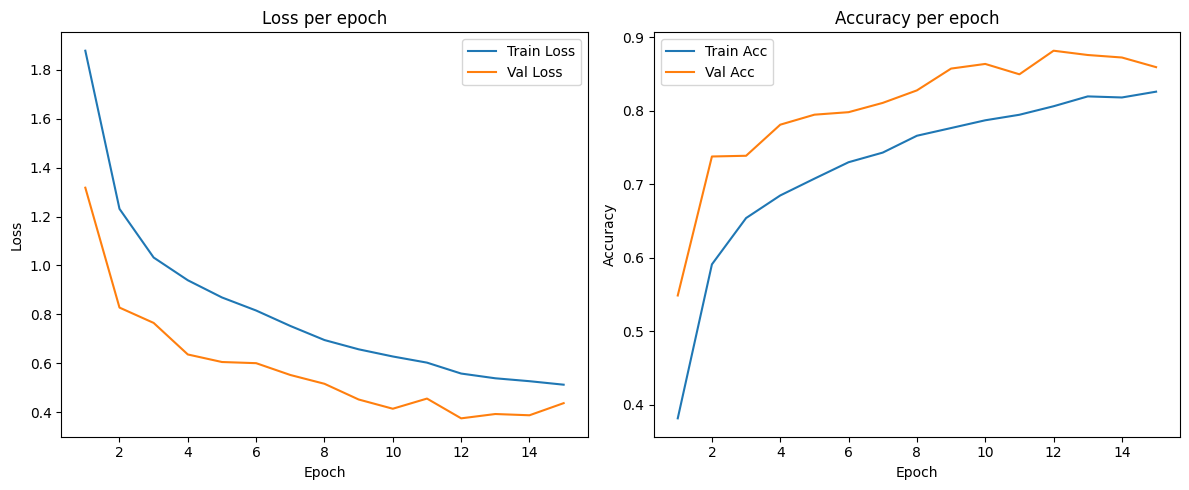

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label = 'Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label = 'Train Acc')
plt.plot(range(1, EPOCHS + 1), val_accs, label = 'Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Save model

torch.save(model.state_dict(), "D:/saved_models/baseline_cnn.pt")

# Test model

test_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/test", transform = val_transform)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

loaded_model = SimpleCNN(num_classes).to(device)
loaded_model.load_state_dict(torch.load("D:/saved_models/baseline_cnn.pt", weights_only = True))

loaded_model.eval()

test_loss, test_correct = 0.0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = loaded_model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * imgs.size(0)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_loss /= len(test_dataset)
test_acc = test_correct / len(test_dataset)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.4380 | Test Acc: 0.8449
